# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

# Display the device ID for CPU/GPU
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

c:\users\will\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2149828449342017195, name: "/gpu:0"
 device_type: "GPU"
 memory_limit: 3272225587
 locality {
   bus_id: 1
 }
 incarnation: 4755613637989082171
 physical_device_desc: "device: 0, name: GeForce GTX 960M, pci bus id: 0000:02:00.0"]

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # DONE Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # DONE Upsample the small input layer using the bilinear_upsample() function.
    upsampled = bilinear_upsample(small_ip_layer)
    
    # DONE Concatenate the upsampled and large input layers using layers.concatenate
    concat_layers = layers.concatenate([upsampled, large_ip_layer])
    
    # DONE Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(concat_layers, filters, 1)
    output_layer = separable_conv2d_batchnorm(output_layer, filters, 1)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    encoder_1 = encoder_block(inputs, filters=32, strides=2)
    encoder_2 = encoder_block(encoder_1, filters=64, strides=2)
    encoder_3 = encoder_block(encoder_2, filters=128, strides=2)
    
    print("encoder_1: ", encoder_1.shape)
    print("encoder_2: ", encoder_2.shape)
    print("encoder_3: ", encoder_3.shape)

    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    conv1 = conv2d_batchnorm(encoder_3, filters=256, kernel_size=1, strides=1)
    
    print("1x1 Conv: ", conv1.shape)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    decoder_1 = decoder_block(conv1, encoder_2, filters=128)
    decoder_2 = decoder_block(decoder_1, encoder_1, filters=64)
    decoder_3 = decoder_block(decoder_2, inputs, filters=32)
    
    print("decoder_1: ", decoder_1.shape)
    print("decoder_2: ", decoder_2.shape)
    print("decoder_3: ", decoder_3.shape) 
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(decoder_3)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

encoder_1:  (?, 80, 80, 32)
encoder_2:  (?, 40, 40, 64)
encoder_3:  (?, 20, 20, 128)
1x1 Conv:  (?, 20, 20, 256)
decoder_1:  (?, 40, 40, 128)
decoder_2:  (?, 80, 80, 64)
decoder_3:  (?, 160, 160, 32)


### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [8]:
# Get number of training and validation data
train_dir = "../data/train/images"
valid_dir = "../data/validation/images"
train_num = len(os.listdir(train_dir)) # dir is your directory path
valid_num = len(os.listdir(valid_dir)) # dir is your directory path

learning_rate = 0.004
batch_size = 40
num_epochs = 100
steps_per_epoch = int(train_num/batch_size) #200
validation_steps = int(valid_num/batch_size) #50
workers = 1 # Utilising the GPU

print("Number of training images: ", train_num)
print("Number of validation images: ", valid_num)
print("Steps per epoch: ", steps_per_epoch)
print("Validation steps: ", validation_steps)

Number of training images:  4131
Number of validation images:  1184
Steps per epoch:  103
Validation steps:  29


Epoch 1/100
102/103 [============================>.] - ETA: 1s - loss: 0.2439

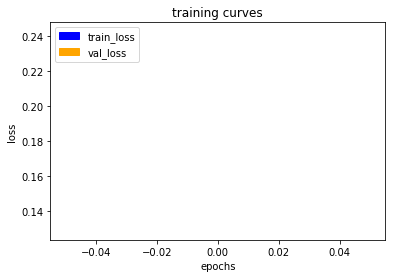

103/103 [==============================] - 171s - loss: 0.2420 - val_loss: 0.1291
Epoch 2/100
102/103 [============================>.] - ETA: 1s - loss: 0.0442

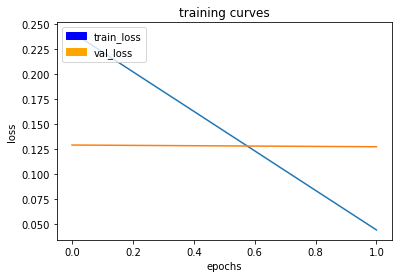

103/103 [==============================] - 167s - loss: 0.0442 - val_loss: 0.1274
Epoch 3/100
102/103 [============================>.] - ETA: 1s - loss: 0.0384

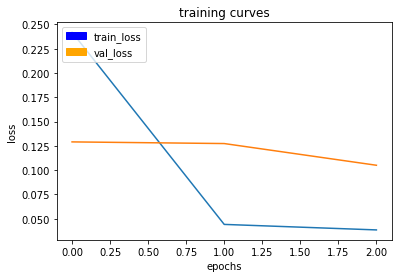

103/103 [==============================] - 166s - loss: 0.0384 - val_loss: 0.1051
Epoch 4/100
102/103 [============================>.] - ETA: 1s - loss: 0.0345

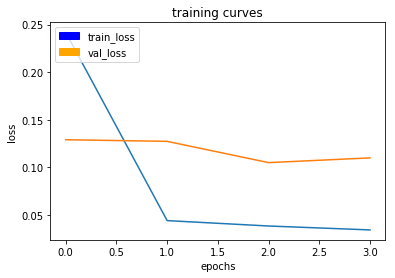

103/103 [==============================] - 166s - loss: 0.0344 - val_loss: 0.1101
Epoch 5/100
102/103 [============================>.] - ETA: 1s - loss: 0.0323

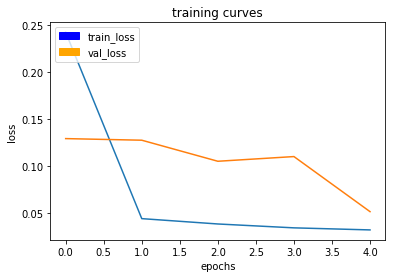

103/103 [==============================] - 166s - loss: 0.0323 - val_loss: 0.0516
Epoch 6/100
102/103 [============================>.] - ETA: 1s - loss: 0.0290

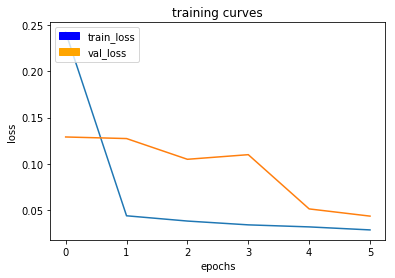

103/103 [==============================] - 165s - loss: 0.0289 - val_loss: 0.0438
Epoch 7/100
102/103 [============================>.] - ETA: 1s - loss: 0.0331

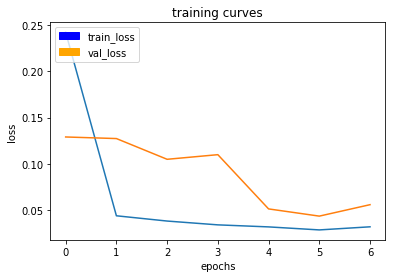

103/103 [==============================] - 166s - loss: 0.0330 - val_loss: 0.0562
Epoch 8/100
102/103 [============================>.] - ETA: 1s - loss: 0.0274

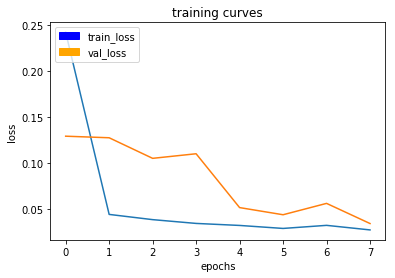

103/103 [==============================] - 166s - loss: 0.0274 - val_loss: 0.0343
Epoch 9/100
102/103 [============================>.] - ETA: 1s - loss: 0.0253

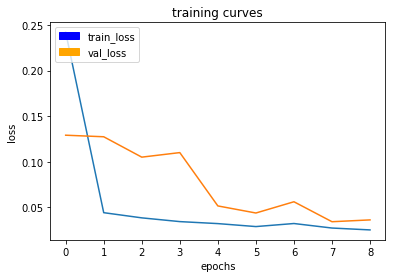

103/103 [==============================] - 166s - loss: 0.0253 - val_loss: 0.0363
Epoch 10/100
102/103 [============================>.] - ETA: 1s - loss: 0.0245

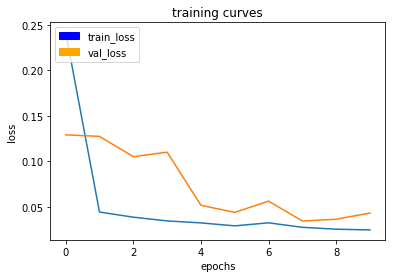

103/103 [==============================] - 166s - loss: 0.0244 - val_loss: 0.0431
Epoch 11/100
102/103 [============================>.] - ETA: 1s - loss: 0.0234

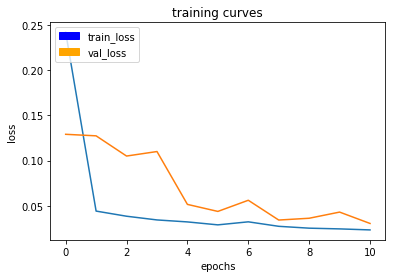

103/103 [==============================] - 166s - loss: 0.0234 - val_loss: 0.0305
Epoch 12/100
102/103 [============================>.] - ETA: 1s - loss: 0.0236

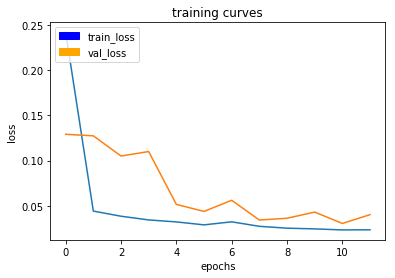

103/103 [==============================] - 166s - loss: 0.0236 - val_loss: 0.0402
Epoch 13/100
102/103 [============================>.] - ETA: 1s - loss: 0.0217

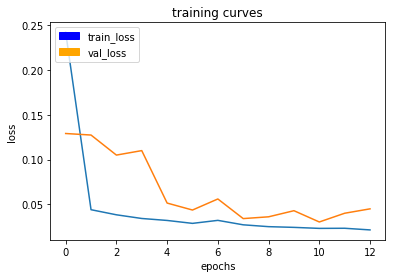

103/103 [==============================] - 166s - loss: 0.0217 - val_loss: 0.0451
Epoch 14/100
102/103 [============================>.] - ETA: 1s - loss: 0.0209

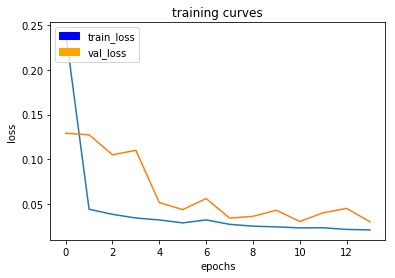

103/103 [==============================] - 166s - loss: 0.0211 - val_loss: 0.0302
Epoch 15/100
102/103 [============================>.] - ETA: 1s - loss: 0.0205

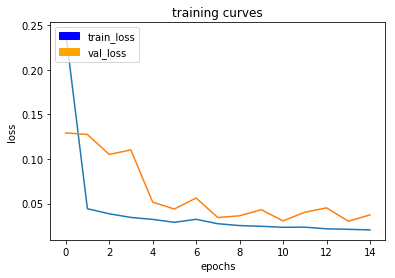

103/103 [==============================] - 167s - loss: 0.0204 - val_loss: 0.0373
Epoch 16/100
102/103 [============================>.] - ETA: 1s - loss: 0.0216

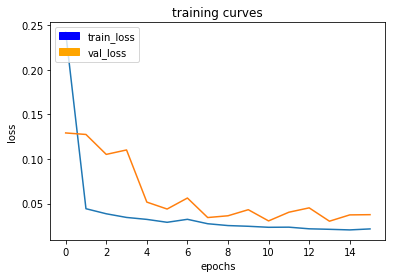

103/103 [==============================] - 166s - loss: 0.0217 - val_loss: 0.0375
Epoch 17/100
102/103 [============================>.] - ETA: 1s - loss: 0.0198

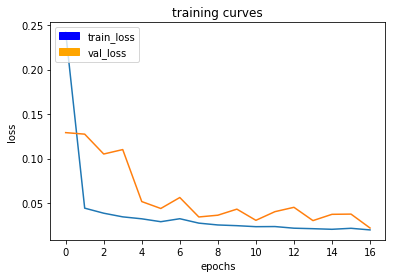

103/103 [==============================] - 167s - loss: 0.0197 - val_loss: 0.0219
Epoch 18/100
102/103 [============================>.] - ETA: 1s - loss: 0.0176

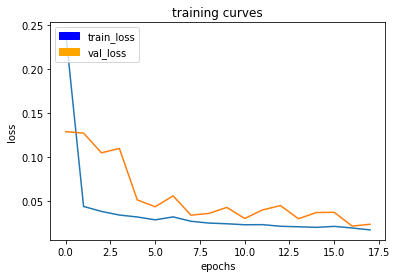

103/103 [==============================] - 166s - loss: 0.0176 - val_loss: 0.0239
Epoch 19/100
102/103 [============================>.] - ETA: 1s - loss: 0.0191

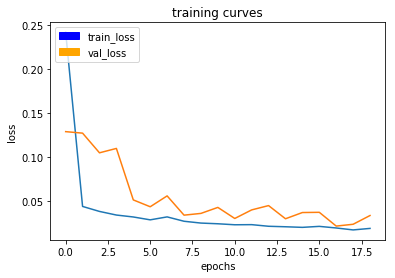

103/103 [==============================] - 165s - loss: 0.0192 - val_loss: 0.0339
Epoch 20/100
102/103 [============================>.] - ETA: 1s - loss: 0.0180

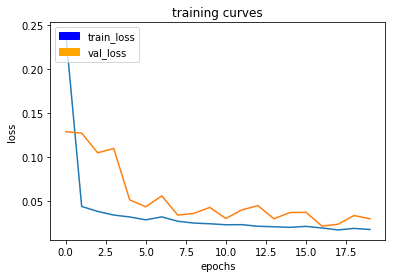

103/103 [==============================] - 165s - loss: 0.0180 - val_loss: 0.0302
Epoch 21/100
102/103 [============================>.] - ETA: 1s - loss: 0.0155

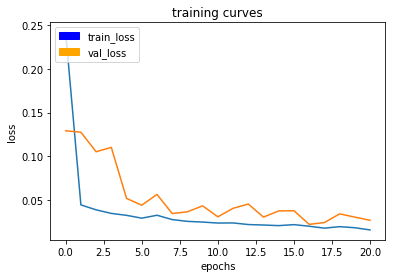

103/103 [==============================] - 165s - loss: 0.0155 - val_loss: 0.0265
Epoch 22/100
102/103 [============================>.] - ETA: 1s - loss: 0.0192

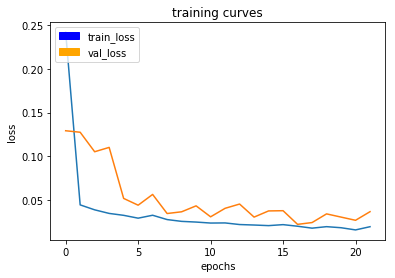

103/103 [==============================] - 165s - loss: 0.0192 - val_loss: 0.0364
Epoch 23/100
102/103 [============================>.] - ETA: 1s - loss: 0.0170

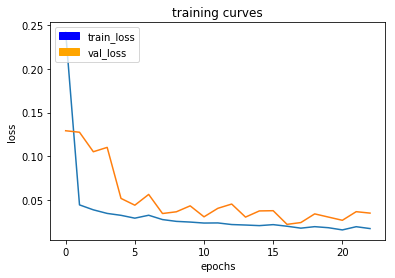

103/103 [==============================] - 165s - loss: 0.0170 - val_loss: 0.0347
Epoch 24/100
102/103 [============================>.] - ETA: 1s - loss: 0.0164

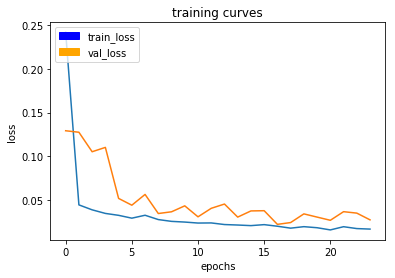

103/103 [==============================] - 165s - loss: 0.0164 - val_loss: 0.0270
Epoch 25/100
102/103 [============================>.] - ETA: 1s - loss: 0.0144

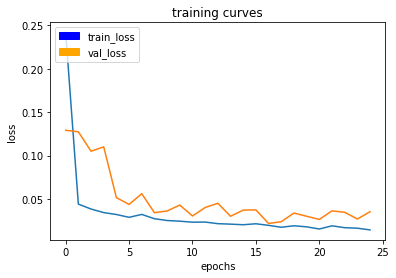

103/103 [==============================] - 166s - loss: 0.0144 - val_loss: 0.0354
Epoch 26/100
102/103 [============================>.] - ETA: 1s - loss: 0.0154

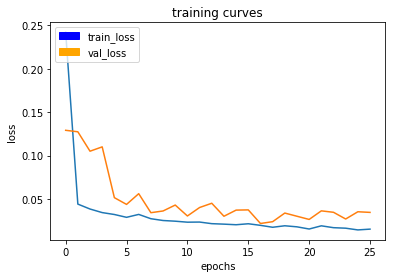

103/103 [==============================] - 165s - loss: 0.0154 - val_loss: 0.0346
Epoch 27/100
102/103 [============================>.] - ETA: 1s - loss: 0.0164

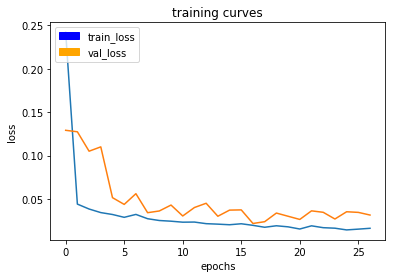

103/103 [==============================] - 165s - loss: 0.0164 - val_loss: 0.0316
Epoch 28/100
102/103 [============================>.] - ETA: 1s - loss: 0.0175

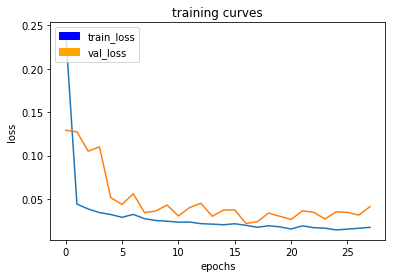

103/103 [==============================] - 166s - loss: 0.0175 - val_loss: 0.0413
Epoch 29/100
102/103 [============================>.] - ETA: 1s - loss: 0.0146

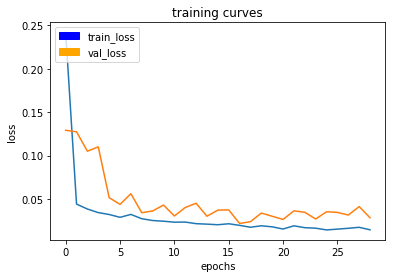

103/103 [==============================] - 165s - loss: 0.0146 - val_loss: 0.0284
Epoch 30/100
102/103 [============================>.] - ETA: 1s - loss: 0.0138

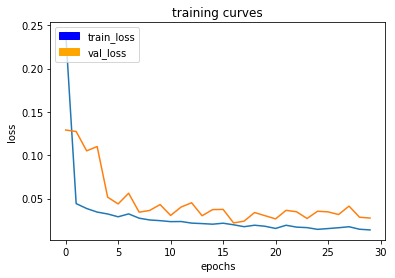

103/103 [==============================] - 165s - loss: 0.0138 - val_loss: 0.0275
Epoch 31/100
102/103 [============================>.] - ETA: 1s - loss: 0.0147

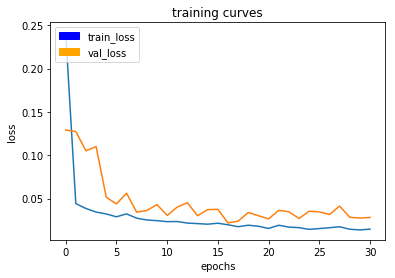

103/103 [==============================] - 165s - loss: 0.0146 - val_loss: 0.0282
Epoch 32/100
102/103 [============================>.] - ETA: 1s - loss: 0.0155

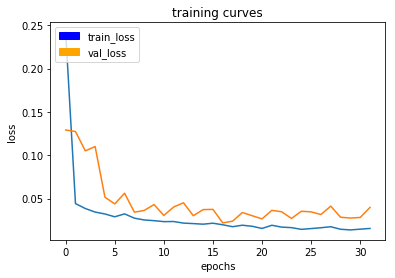

103/103 [==============================] - 166s - loss: 0.0155 - val_loss: 0.0398
Epoch 33/100
102/103 [============================>.] - ETA: 1s - loss: 0.0146

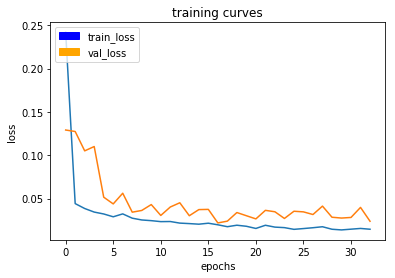

103/103 [==============================] - 165s - loss: 0.0146 - val_loss: 0.0238
Epoch 34/100
102/103 [============================>.] - ETA: 1s - loss: 0.0153

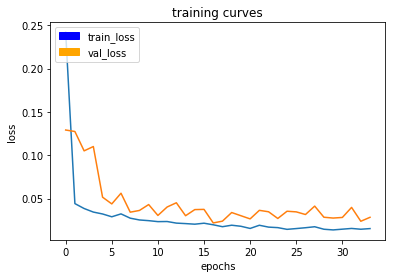

103/103 [==============================] - 166s - loss: 0.0153 - val_loss: 0.0284
Epoch 35/100
102/103 [============================>.] - ETA: 1s - loss: 0.0154

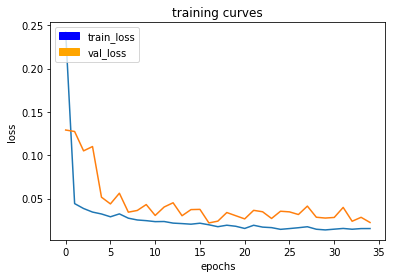

103/103 [==============================] - 165s - loss: 0.0153 - val_loss: 0.0224
Epoch 36/100
102/103 [============================>.] - ETA: 1s - loss: 0.0159

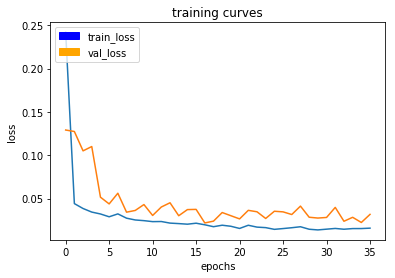

103/103 [==============================] - 166s - loss: 0.0158 - val_loss: 0.0317
Epoch 37/100
102/103 [============================>.] - ETA: 1s - loss: 0.0140

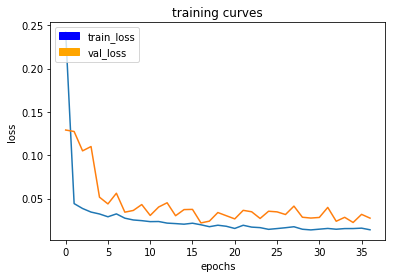

103/103 [==============================] - 166s - loss: 0.0139 - val_loss: 0.0274
Epoch 38/100
102/103 [============================>.] - ETA: 1s - loss: 0.0134

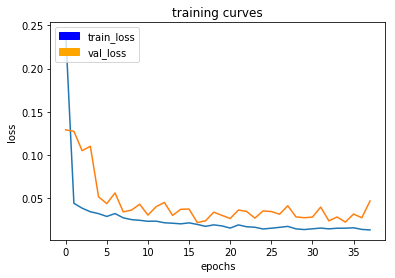

103/103 [==============================] - 166s - loss: 0.0134 - val_loss: 0.0468
Epoch 39/100
102/103 [============================>.] - ETA: 1s - loss: 0.0125

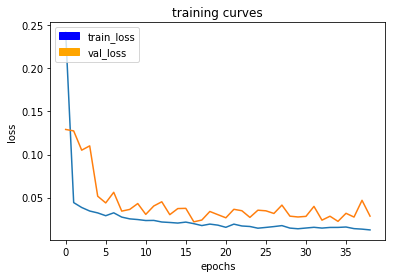

103/103 [==============================] - 166s - loss: 0.0125 - val_loss: 0.0285
Epoch 40/100
102/103 [============================>.] - ETA: 1s - loss: 0.0124

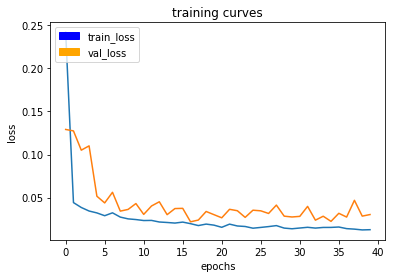

103/103 [==============================] - 166s - loss: 0.0127 - val_loss: 0.0303
Epoch 41/100
102/103 [============================>.] - ETA: 1s - loss: 0.0124

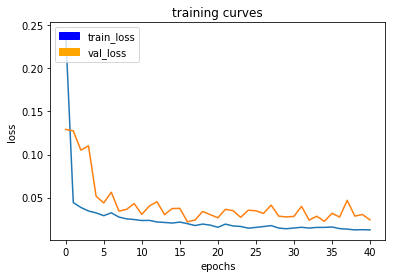

103/103 [==============================] - 166s - loss: 0.0124 - val_loss: 0.0241
Epoch 42/100
102/103 [============================>.] - ETA: 1s - loss: 0.0120

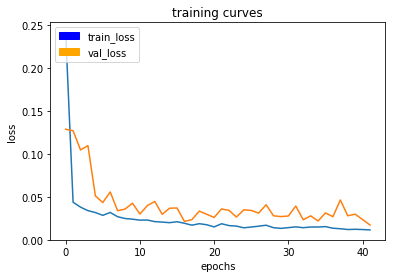

103/103 [==============================] - 165s - loss: 0.0120 - val_loss: 0.0177
Epoch 43/100
102/103 [============================>.] - ETA: 1s - loss: 0.0111

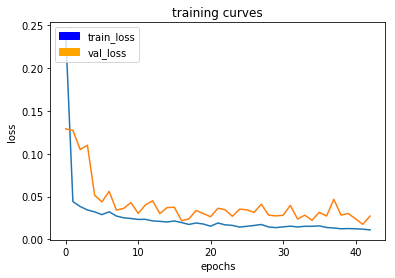

103/103 [==============================] - 165s - loss: 0.0111 - val_loss: 0.0273
Epoch 44/100
102/103 [============================>.] - ETA: 1s - loss: 0.0105

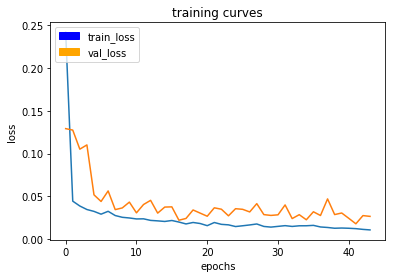

103/103 [==============================] - 166s - loss: 0.0105 - val_loss: 0.0264
Epoch 45/100
102/103 [============================>.] - ETA: 1s - loss: 0.0111

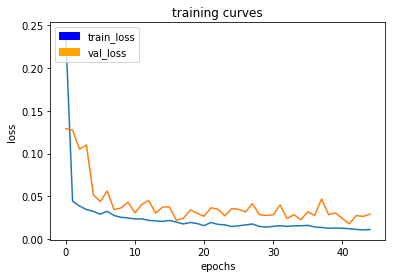

103/103 [==============================] - 166s - loss: 0.0111 - val_loss: 0.0290
Epoch 46/100
102/103 [============================>.] - ETA: 1s - loss: 0.0113

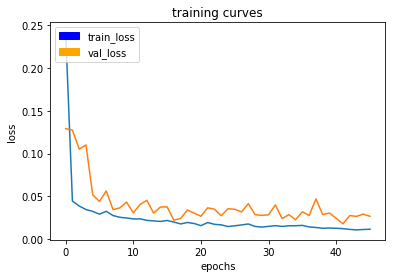

103/103 [==============================] - 165s - loss: 0.0113 - val_loss: 0.0264
Epoch 47/100
102/103 [============================>.] - ETA: 1s - loss: 0.0141

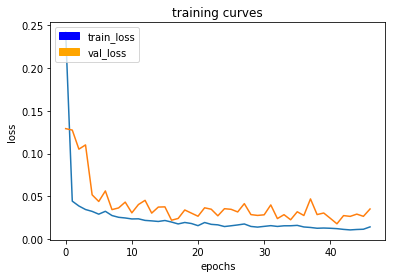

103/103 [==============================] - 165s - loss: 0.0141 - val_loss: 0.0350
Epoch 48/100
102/103 [============================>.] - ETA: 1s - loss: 0.0124

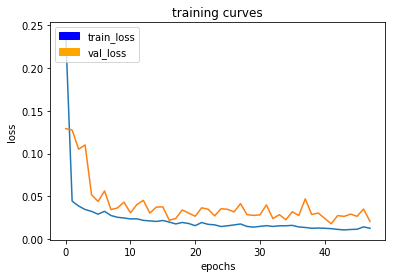

103/103 [==============================] - 165s - loss: 0.0124 - val_loss: 0.0204
Epoch 49/100
102/103 [============================>.] - ETA: 1s - loss: 0.0167

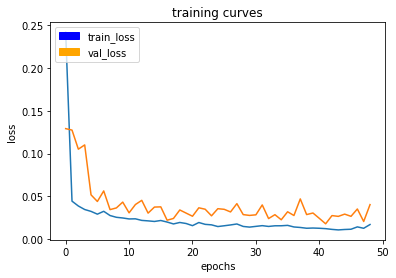

103/103 [==============================] - 165s - loss: 0.0168 - val_loss: 0.0401
Epoch 50/100
102/103 [============================>.] - ETA: 1s - loss: 0.0145

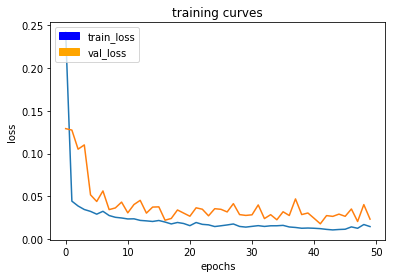

103/103 [==============================] - 166s - loss: 0.0145 - val_loss: 0.0231
Epoch 51/100
102/103 [============================>.] - ETA: 1s - loss: 0.0125

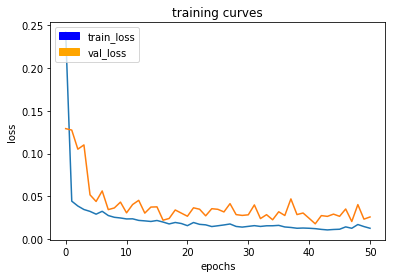

103/103 [==============================] - 165s - loss: 0.0125 - val_loss: 0.0257
Epoch 52/100
102/103 [============================>.] - ETA: 1s - loss: 0.0123

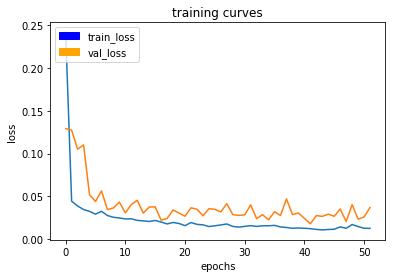

103/103 [==============================] - 166s - loss: 0.0123 - val_loss: 0.0367
Epoch 53/100
102/103 [============================>.] - ETA: 1s - loss: 0.0107

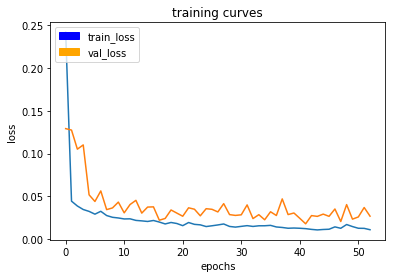

103/103 [==============================] - 166s - loss: 0.0107 - val_loss: 0.0266
Epoch 54/100
102/103 [============================>.] - ETA: 1s - loss: 0.0120

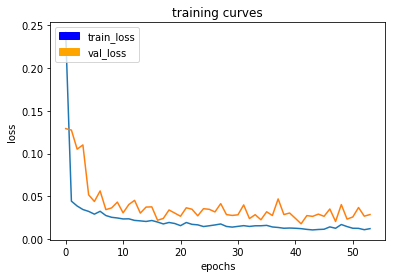

103/103 [==============================] - 166s - loss: 0.0120 - val_loss: 0.0285
Epoch 55/100
102/103 [============================>.] - ETA: 1s - loss: 0.0111

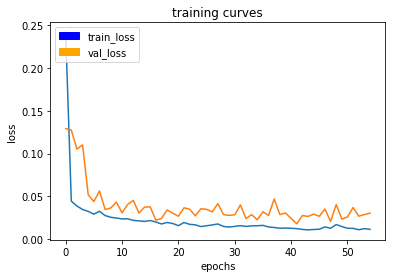

103/103 [==============================] - 166s - loss: 0.0112 - val_loss: 0.0302
Epoch 56/100
102/103 [============================>.] - ETA: 1s - loss: 0.0103

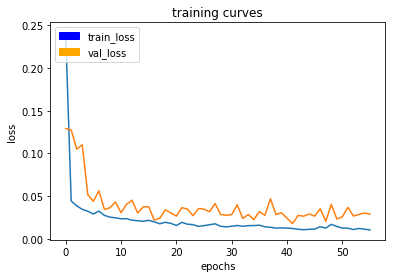

103/103 [==============================] - 166s - loss: 0.0103 - val_loss: 0.0288
Epoch 57/100
102/103 [============================>.] - ETA: 1s - loss: 0.0113

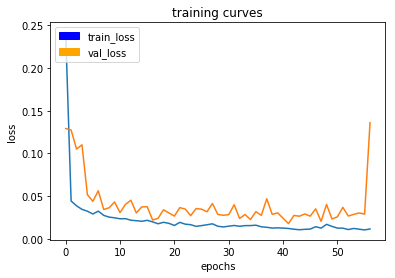

103/103 [==============================] - 165s - loss: 0.0114 - val_loss: 0.1360
Epoch 58/100
102/103 [============================>.] - ETA: 1s - loss: 0.0162

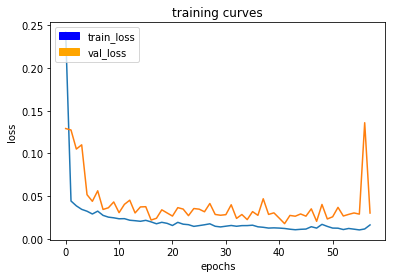

103/103 [==============================] - 166s - loss: 0.0162 - val_loss: 0.0301
Epoch 59/100
102/103 [============================>.] - ETA: 1s - loss: 0.0120

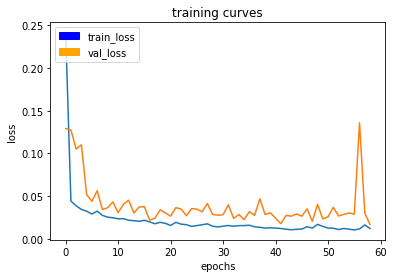

103/103 [==============================] - 165s - loss: 0.0120 - val_loss: 0.0166
Epoch 60/100
102/103 [============================>.] - ETA: 1s - loss: 0.0117

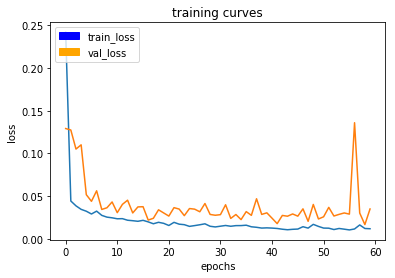

103/103 [==============================] - 166s - loss: 0.0117 - val_loss: 0.0348
Epoch 61/100
102/103 [============================>.] - ETA: 1s - loss: 0.0110

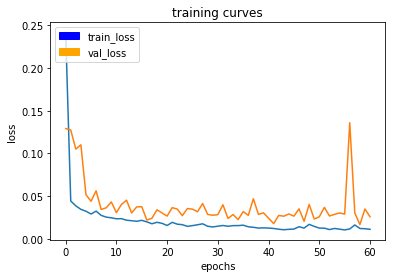

103/103 [==============================] - 166s - loss: 0.0110 - val_loss: 0.0257
Epoch 62/100
102/103 [============================>.] - ETA: 1s - loss: 0.0108

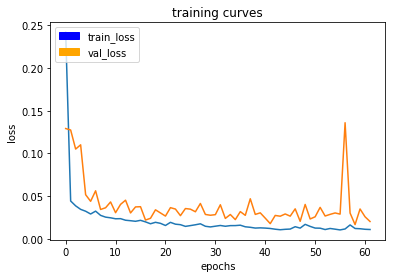

103/103 [==============================] - 165s - loss: 0.0108 - val_loss: 0.0201
Epoch 63/100
102/103 [============================>.] - ETA: 1s - loss: 0.0099

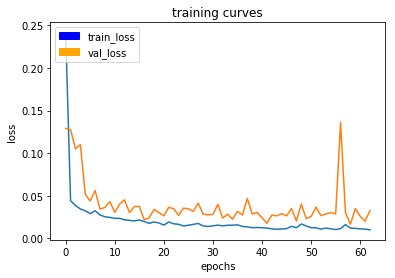

103/103 [==============================] - 165s - loss: 0.0099 - val_loss: 0.0327
Epoch 64/100
102/103 [============================>.] - ETA: 1s - loss: 0.0097

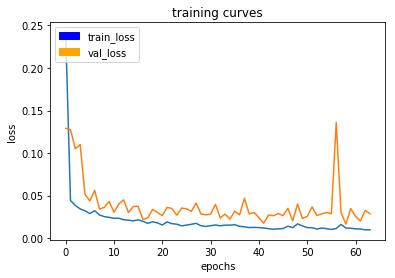

103/103 [==============================] - 165s - loss: 0.0097 - val_loss: 0.0286
Epoch 65/100
102/103 [============================>.] - ETA: 1s - loss: 0.0106

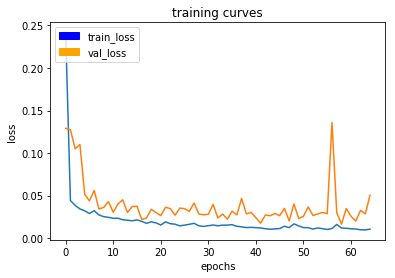

103/103 [==============================] - 165s - loss: 0.0106 - val_loss: 0.0505
Epoch 66/100
102/103 [============================>.] - ETA: 1s - loss: 0.0127

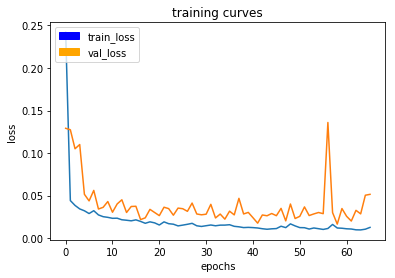

103/103 [==============================] - 165s - loss: 0.0127 - val_loss: 0.0515
Epoch 67/100
102/103 [============================>.] - ETA: 1s - loss: 0.0121

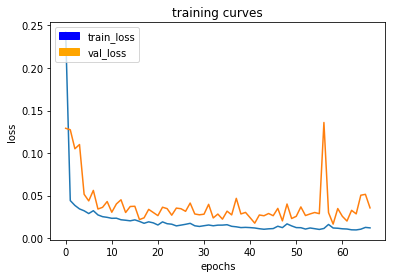

103/103 [==============================] - 165s - loss: 0.0121 - val_loss: 0.0356
Epoch 68/100
102/103 [============================>.] - ETA: 1s - loss: 0.0109

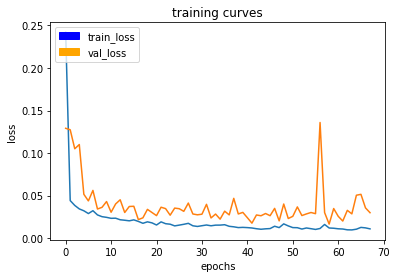

103/103 [==============================] - 165s - loss: 0.0109 - val_loss: 0.0299
Epoch 69/100
102/103 [============================>.] - ETA: 1s - loss: 0.0099

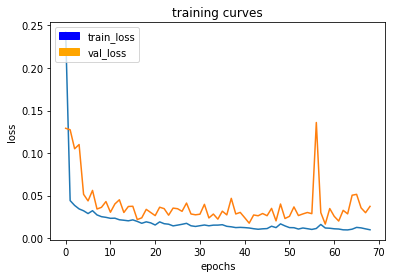

103/103 [==============================] - 165s - loss: 0.0099 - val_loss: 0.0374
Epoch 70/100
102/103 [============================>.] - ETA: 1s - loss: 0.0101

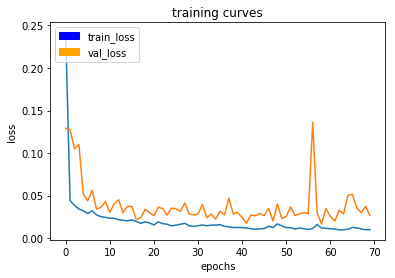

103/103 [==============================] - 165s - loss: 0.0101 - val_loss: 0.0266
Epoch 71/100
102/103 [============================>.] - ETA: 1s - loss: 0.0104

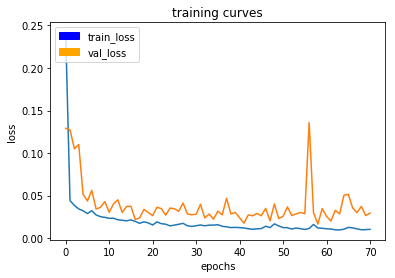

103/103 [==============================] - 165s - loss: 0.0104 - val_loss: 0.0295
Epoch 72/100
102/103 [============================>.] - ETA: 1s - loss: 0.0099

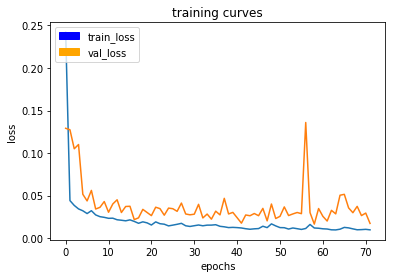

103/103 [==============================] - 165s - loss: 0.0098 - val_loss: 0.0174
Epoch 73/100
102/103 [============================>.] - ETA: 1s - loss: 0.0093

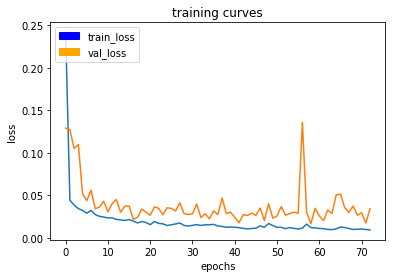

103/103 [==============================] - 165s - loss: 0.0093 - val_loss: 0.0343
Epoch 74/100
102/103 [============================>.] - ETA: 1s - loss: 0.0114

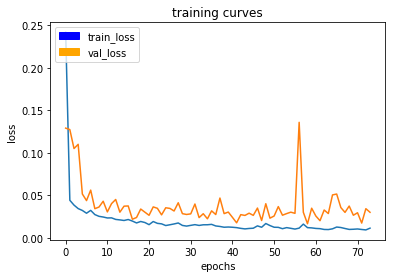

103/103 [==============================] - 165s - loss: 0.0114 - val_loss: 0.0300
Epoch 75/100
102/103 [============================>.] - ETA: 1s - loss: 0.0144

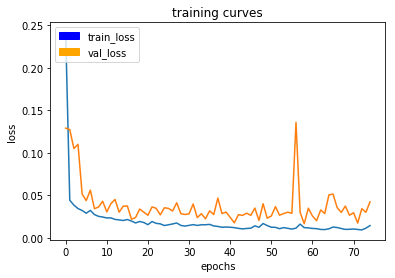

103/103 [==============================] - 165s - loss: 0.0144 - val_loss: 0.0424
Epoch 76/100
102/103 [============================>.] - ETA: 1s - loss: 0.0116

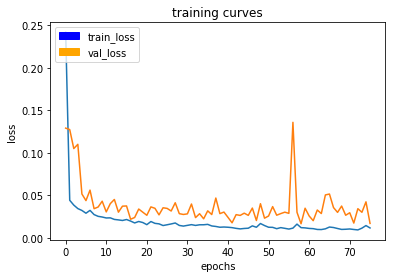

103/103 [==============================] - 166s - loss: 0.0116 - val_loss: 0.0169
Epoch 77/100
102/103 [============================>.] - ETA: 1s - loss: 0.0097

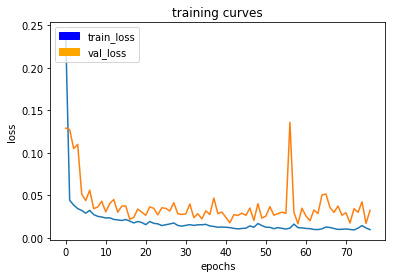

103/103 [==============================] - 166s - loss: 0.0097 - val_loss: 0.0324
Epoch 78/100
102/103 [============================>.] - ETA: 1s - loss: 0.0093

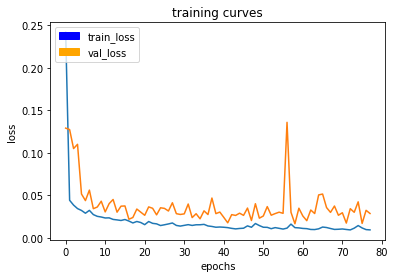

103/103 [==============================] - 165s - loss: 0.0093 - val_loss: 0.0286
Epoch 79/100
102/103 [============================>.] - ETA: 1s - loss: 0.0092

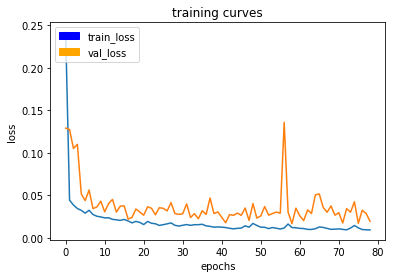

103/103 [==============================] - 165s - loss: 0.0092 - val_loss: 0.0193
Epoch 80/100
102/103 [============================>.] - ETA: 1s - loss: 0.0090

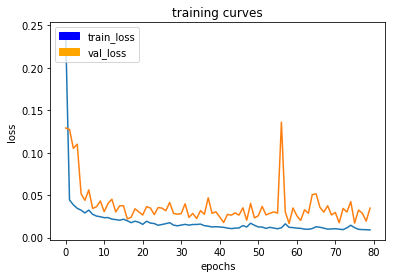

103/103 [==============================] - 165s - loss: 0.0090 - val_loss: 0.0347
Epoch 81/100
102/103 [============================>.] - ETA: 1s - loss: 0.0090

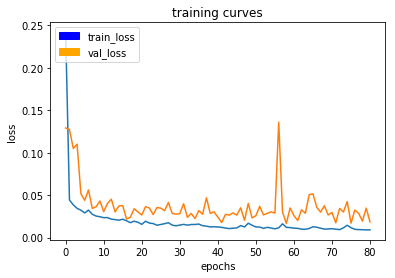

103/103 [==============================] - 164s - loss: 0.0090 - val_loss: 0.0184
Epoch 82/100
102/103 [============================>.] - ETA: 1s - loss: 0.0091

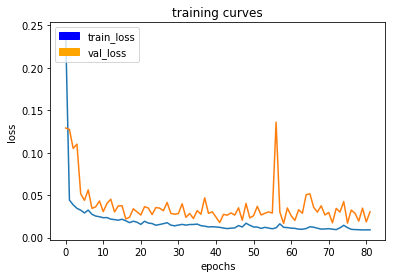

103/103 [==============================] - 165s - loss: 0.0090 - val_loss: 0.0303
Epoch 83/100
102/103 [============================>.] - ETA: 1s - loss: 0.0097

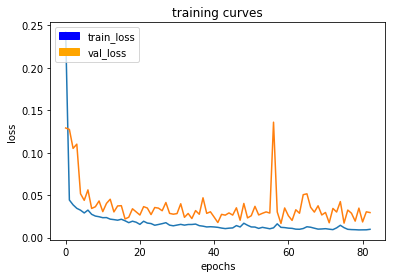

103/103 [==============================] - 164s - loss: 0.0097 - val_loss: 0.0294
Epoch 84/100
102/103 [============================>.] - ETA: 1s - loss: 0.0093

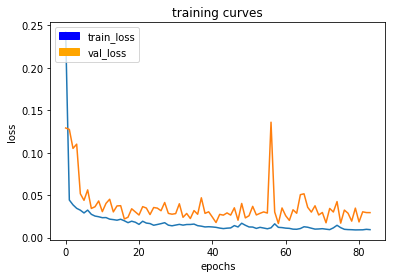

103/103 [==============================] - 165s - loss: 0.0093 - val_loss: 0.0293
Epoch 85/100
102/103 [============================>.] - ETA: 1s - loss: 0.0099

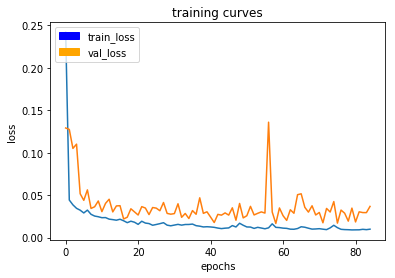

103/103 [==============================] - 165s - loss: 0.0099 - val_loss: 0.0367
Epoch 86/100
102/103 [============================>.] - ETA: 1s - loss: 0.0126

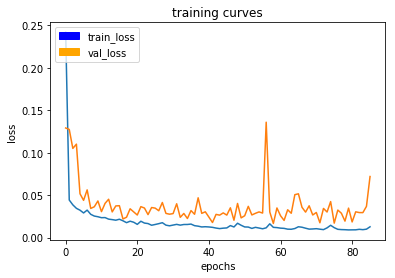

103/103 [==============================] - 165s - loss: 0.0126 - val_loss: 0.0719
Epoch 87/100
102/103 [============================>.] - ETA: 1s - loss: 0.0158

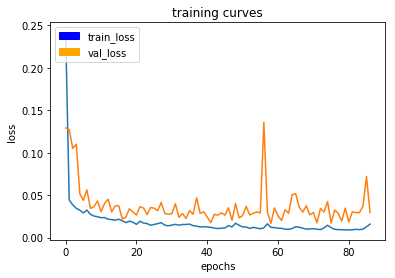

103/103 [==============================] - 165s - loss: 0.0158 - val_loss: 0.0294
Epoch 88/100
102/103 [============================>.] - ETA: 1s - loss: 0.0154

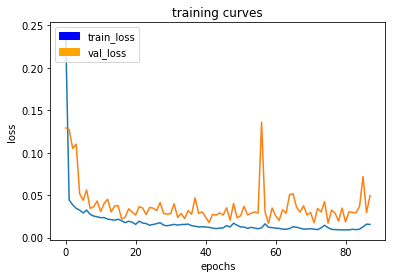

103/103 [==============================] - 165s - loss: 0.0154 - val_loss: 0.0494
Epoch 89/100
102/103 [============================>.] - ETA: 1s - loss: 0.0136

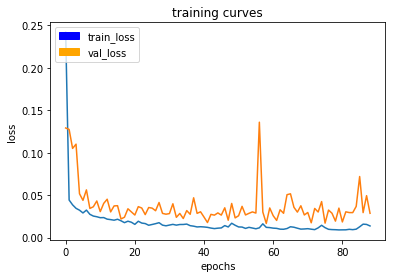

103/103 [==============================] - 165s - loss: 0.0136 - val_loss: 0.0285
Epoch 90/100
102/103 [============================>.] - ETA: 1s - loss: 0.0116

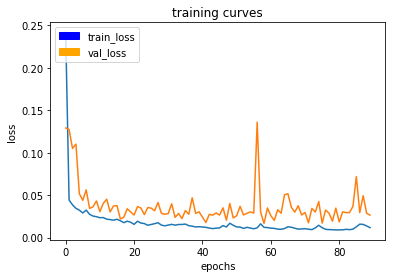

103/103 [==============================] - 165s - loss: 0.0116 - val_loss: 0.0264
Epoch 91/100
102/103 [============================>.] - ETA: 1s - loss: 0.0100

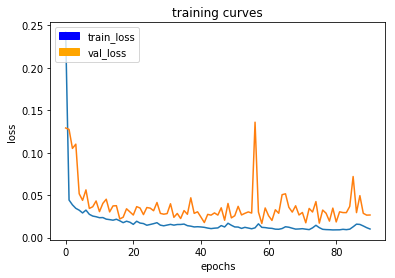

103/103 [==============================] - 166s - loss: 0.0100 - val_loss: 0.0265
Epoch 92/100
102/103 [============================>.] - ETA: 1s - loss: 0.0096

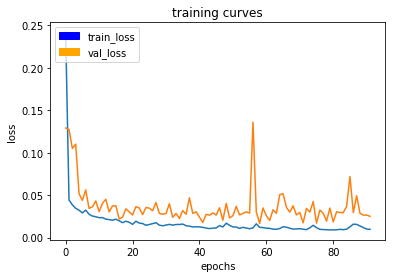

103/103 [==============================] - 166s - loss: 0.0096 - val_loss: 0.0249
Epoch 93/100
102/103 [============================>.] - ETA: 1s - loss: 0.0095

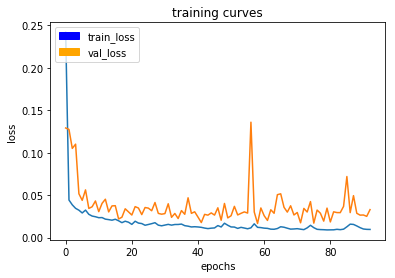

103/103 [==============================] - 165s - loss: 0.0095 - val_loss: 0.0329
Epoch 94/100
102/103 [============================>.] - ETA: 1s - loss: 0.0091

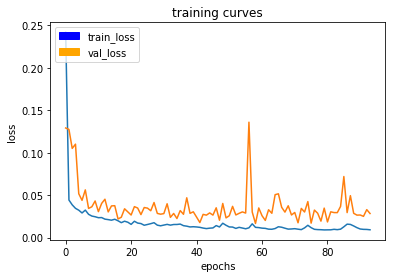

103/103 [==============================] - 165s - loss: 0.0091 - val_loss: 0.0283
Epoch 95/100
102/103 [============================>.] - ETA: 1s - loss: 0.0088

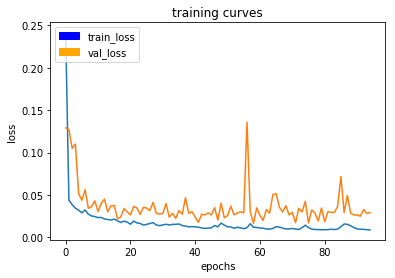

103/103 [==============================] - 165s - loss: 0.0088 - val_loss: 0.0293
Epoch 96/100
102/103 [============================>.] - ETA: 1s - loss: 0.0088

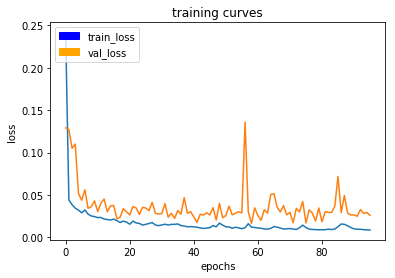

103/103 [==============================] - 164s - loss: 0.0088 - val_loss: 0.0259
Epoch 97/100
102/103 [============================>.] - ETA: 1s - loss: 0.0087

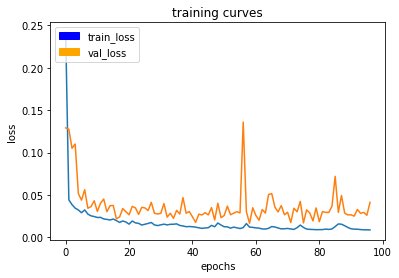

103/103 [==============================] - 165s - loss: 0.0087 - val_loss: 0.0412
Epoch 98/100
102/103 [============================>.] - ETA: 1s - loss: 0.0088

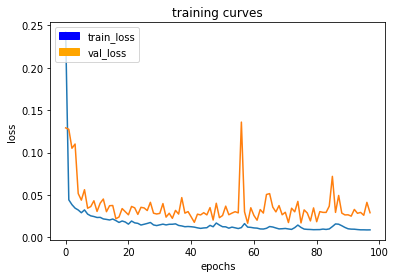

103/103 [==============================] - 164s - loss: 0.0088 - val_loss: 0.0290
Epoch 99/100
102/103 [============================>.] - ETA: 1s - loss: 0.0087

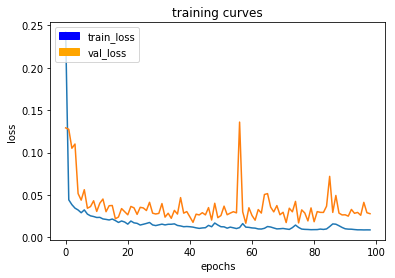

103/103 [==============================] - 164s - loss: 0.0087 - val_loss: 0.0278
Epoch 100/100
102/103 [============================>.] - ETA: 1s - loss: 0.0085

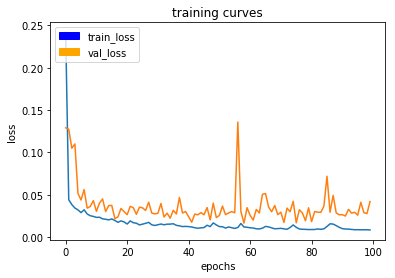

103/103 [==============================] - 164s - loss: 0.0085 - val_loss: 0.0420


In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

#from tensorflow.contrib.keras.python.keras.models import load_model
#model = load_model('epochs_20.h5')

# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)
model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [10]:
# count the number of files in the directory
weight_directory = "../data/weights"
weight_num = int(len(os.listdir(weight_directory)) / 2) + 1 # dir is your directory path

# Save your trained model weights
weight_file_name = 'model_weights_v' + str(weight_num)
model_tools.save_network(model, weight_file_name)

### Save model for recommencing training

In [11]:
#model.save('epochs_40.h5')
#del model  # deletes the existing model
#from tensorflow.contrib.keras.python.keras.models import load_model
#model = load_model('epochs_40.h5')

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [12]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

weight_file_name = 'model_weights_v5'
model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [13]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

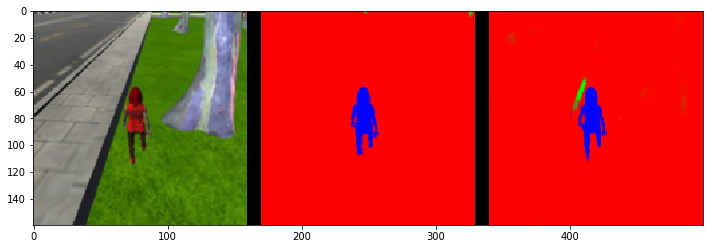

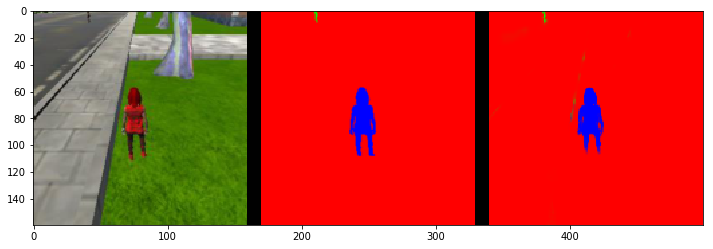

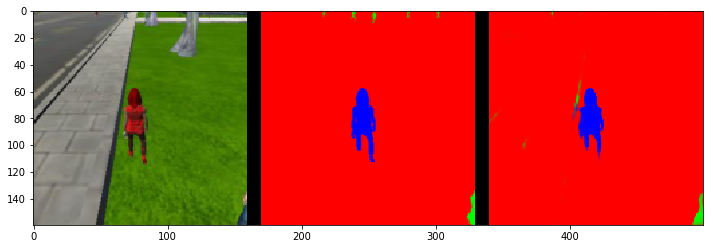

In [14]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

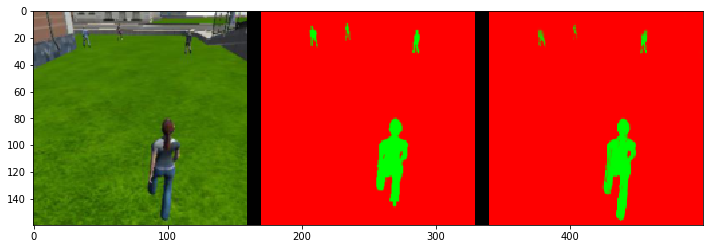

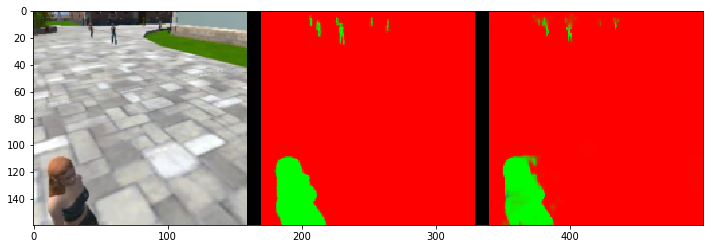

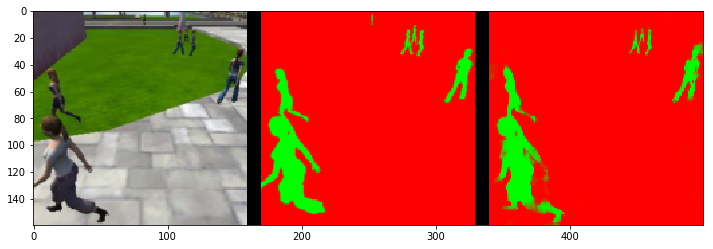

In [15]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

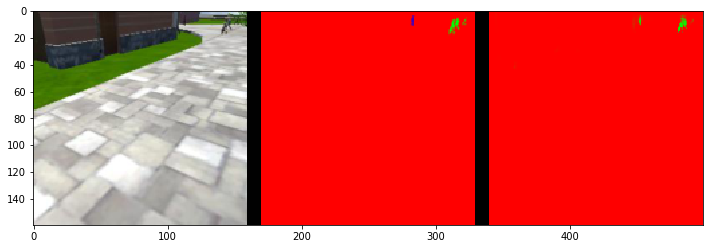

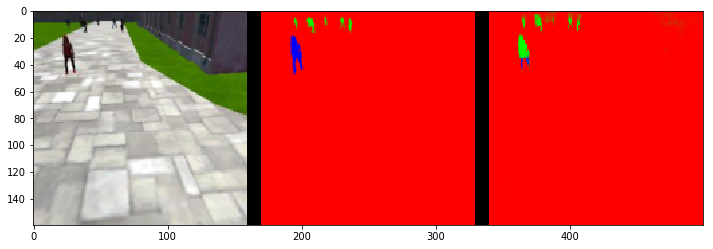

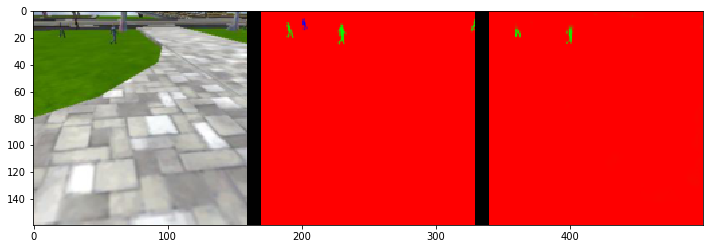

In [16]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [17]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9959894887194934
average intersection over union for other people is 0.3535838875651621
average intersection over union for the hero is 0.8873659110337639
number true positives: 538, number false positives: 0, number false negatives: 1


In [18]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.989052369477025
average intersection over union for other people is 0.7837534270860241
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 22, number false negatives: 0


In [19]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9965445376424418
average intersection over union for other people is 0.4244122518556712
average intersection over union for the hero is 0.1465922498066024
number true positives: 97, number false positives: 0, number false negatives: 204


In [20]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7366589327146171


In [21]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.5169790804201831


In [22]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.3808372576181163
